In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
from preprocess import *
from utils import *
import numpy as np
import matplotlib.pyplot as plt
import harmonypy as hm

from train import Train

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
savepath = 'Result'
if not os.path.exists(savepath):
    os.mkdir(savepath)

In [4]:
datasets_df = pd.DataFrame([['151507', '151508', '151509', '151510'],
                                ['151669', '151670', '151671', '151672'],
                                ['151673', '151674', '151675', '151676']])
datasets_df.index = ['Sample1', 'Sample2', 'Sample3']
datasets_df.columns = ['Location1', 'Location2', 'Location3', 'Location4']
batch_tag = 'Sample1'
datasets = datasets_df.loc[batch_tag].values    # Sample
# datasets = datasets_df[batch_tag].values        # Location
dataset_tags = datasets

n_neighbor = 5
n_cluster = 7 if batch_tag != 'Sample2' else 5

epochs = 500
coord_type = 'spatial'
weights = [[60, 0.01, 0.01]]

adata_list = []

for i in range(len(datasets)):
    dataset = datasets[i]
    # print(dataset)
    file_fold = '../../../data/DLPFC/' + str(dataset)
    adata = sc.read_visium(file_fold, count_file=dataset + '_filtered_feature_bc_matrix.h5', load_images=True)
    adata.var_names_make_unique()

    # add ground_truth
    df_meta = pd.read_csv(file_fold + '/manual_annotations.txt', sep='\t', header=None, index_col=0)
    df_meta.columns = ['layer_guess']
    adata.obs['ground_truth'] = df_meta['layer_guess'].values
    # filter out NA nodes
    adata = adata[~pd.isnull(adata.obs['ground_truth'])]

    adata.obs_names = [x + '_' + dataset for x in adata.obs_names]
    adata.obs['batch_name'] = [dataset] * adata.X.shape[0]
    adata_list.append(adata)
    
batch_adata = integrate_adata(adata_list, coord_type=coord_type, n_neighbor=n_neighbor)

D:\anaconda\envs\njy\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
D:\anaconda\envs\njy\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
D:\anaconda\envs\njy\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
D:\anaconda\envs\njy\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
D:\anaconda\envs\njy\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_dup

Recommended l is 276
Recommended l is 276
Recommended l is 278
Recommended l is 278
AnnData object with n_obs × n_vars = 17985 × 21001
    obs: 'in_tissue', 'array_row', 'array_col', 'ground_truth', 'batch_name'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p'
    obsm: 'spatial', 'neighbors', 'feature'
    obsp: 'adj'


In [5]:
for mse_weight, graph_weight, nce_weight in weights:
    set = batch_tag + "_" + str(n_neighbor) + "_" + str(mse_weight) + "_" + str(graph_weight) \
        + "_" + str(nce_weight) + "_" + str(epochs)
    print(set)
    print("*" * 70)
    
    model = Train(batch_adata, device=device, epochs=epochs, mse_weight=mse_weight,
                      graph_weight=graph_weight, nce_weight=nce_weight, coord_type=coord_type,
                      n_neighbor=n_neighbor, n_cluster=n_cluster, protocol='10X')
    batch_adata = model.train()

    # Harmony
    data_mat = batch_adata.obsm['emb'].copy()
    vars_use = ['batch_name']
    meta_data = batch_adata.obs[vars_use]
    # Run Harmony
    ho = hm.run_harmony(data_mat, meta_data, vars_use)
    batch_adata.obsm['Harmony_Revised'] = ho.Z_corr.T

    method = 'mclust'  # mclust, leiden, louvain, kmeans
    cluster(batch_adata, n_clusters=n_cluster, method=method, key='Harmony_Revised')

    domain_tag = 'domain'
    embed_tag = 'Harmony_Revised'

    # filter out NA nodes
    sub_adata = batch_adata[~pd.isnull(batch_adata.obs['ground_truth'])]

    # sc.set_figure_params(vector_friendly=True, figsize=(4.5 / 2.54, 4.5 / 2.54))
    # fig, ax_list = plt.subplots(1, 4, figsize=(5 / 2.54 * 4, 5 / 2.54))
    # ### Plotting UMAP before batch effect correction
    # sc.pp.pca(sub_adata)
    # sc.pp.neighbors(sub_adata, use_rep='X_pca')
    # sc.tl.umap(sub_adata)
    # sc.pl.umap(sub_adata, color='batch_name', title='Uncorrected', ax=ax_list[0], frameon=False,
    #            show=False, size=3, legend_fontsize=5)
    # ### Plotting UMAP after batch effect correction
    # sc.pp.neighbors(sub_adata, use_rep=embed_tag)
    # sc.tl.umap(sub_adata)
    # sc.pl.umap(sub_adata, color='batch_name', ax=ax_list[1], title='Batch corrected', frameon=False,
    #            show=False, size=3, legend_fontsize=5)
    # 
    # sc.pl.umap(sub_adata, color='ground_truth', ax=ax_list[2], title='Ground Truth', frameon=False,
    #            show=False, size=3, legend_fontsize=5)
    # sc.pl.umap(sub_adata, color=domain_tag, ax=ax_list[3], title='Predict Domain', frameon=False,
    #            show=False, size=3, legend_fontsize=5)
    # plt.savefig(savepath + f'SpaGIC_{batch_tag}_umap_hm.png', bbox_inches='tight', dpi=300)
    # # plt.savefig(savepath + f'SpaGIC_{batch_tag}_umap_hm.pdf', bbox_inches='tight', dpi=300)
    # # plt.show()
    # plt.close()

    # scores
    # ARI = adjusted_rand_score(sub_adata.obs['ground_truth'], sub_adata.obs[domain_tag])
    # NMI = normalized_mutual_info_score(sub_adata.obs['ground_truth'], sub_adata.obs[domain_tag])
    # print(f'{batch_tag}, ARI: {ARI}; NMI: {NMI}')

    #### single slice visual
    # sc.set_figure_params(vector_friendly=True, figsize=(3.2 / 2.54, 3.5 / 2.54))
    # fig, axs = plt.subplots(1, len(datasets), figsize=(4.5 * len(datasets), 3))
    # for idx, single_adata in enumerate(adata_list):
    #     single_adata.obs[domain_tag] = batch_adata[batch_adata.obs['batch_name'] == datasets[idx]].obs[domain_tag].values
    #     # filter out NA nodes
    #     sub_adata = single_adata[~pd.isnull(single_adata.obs['ground_truth'])]
    #     refine(sub_adata, radius=50, key=domain_tag)
    #     key = 'domain_refined'
    #     ARI = adjusted_rand_score(sub_adata.obs['ground_truth'], sub_adata.obs[key])
    #     NMI = normalized_mutual_info_score(sub_adata.obs['ground_truth'], sub_adata.obs[key])
    #     print(f'{datasets[idx]}, ARI: {ARI}; NMI: {NMI}')
    #     sc.pl.spatial(sub_adata, img_key="hires", ax=axs[idx], color=key, frameon=False, legend_fontsize=8,
    #                   title=f'{datasets[idx]}_ARI=%.4f-NMI=%.4f' % (ARI, NMI), show=False)
    # plt.savefig(savepath + f'SpaGIC_{batch_tag}_sp_hm.png', bbox_inches='tight', dpi=300)
    # plt.savefig(savepath + f'SpaGIC_{batch_tag}_sp_hm.pdf', bbox_inches='tight', dpi=300)
    # plt.show()
    # plt.close()

Sample1_5_60_0.01_0.01_500
**********************************************************************
Begin to train...


100%|██████████| 500/500 [02:51<00:00,  2.92it/s]


Optimization finished!


2025-01-12 12:13:40,025 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-01-12 12:13:42,515 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-01-12 12:13:42,603 - harmonypy - INFO - Iteration 1 of 10
2025-01-12 12:13:46,559 - harmonypy - INFO - Iteration 2 of 10
2025-01-12 12:13:50,503 - harmonypy - INFO - Iteration 3 of 10
2025-01-12 12:13:54,508 - harmonypy - INFO - Iteration 4 of 10
2025-01-12 12:13:58,471 - harmonypy - INFO - Iteration 5 of 10
2025-01-12 12:14:00,363 - harmonypy - INFO - Iteration 6 of 10
2025-01-12 12:14:01,931 - harmonypy - INFO - Iteration 7 of 10
2025-01-12 12:14:03,567 - harmonypy - INFO - Converged after 7 iterations


clustering...


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [6]:
batch_adata

AnnData object with n_obs × n_vars = 17985 × 21001
    obs: 'in_tissue', 'array_row', 'array_col', 'ground_truth', 'batch_name', 'mclust', 'domain'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p'
    obsm: 'spatial', 'neighbors', 'feature', 'emb', 'rec_feat', 'Harmony_Revised'
    obsp: 'adj'

In [7]:
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics import normalized_mutual_info_score as nmi_score
from sklearn.metrics import adjusted_mutual_info_score as ami_score
from sklearn.metrics import homogeneity_score as hom_score
from sklearn.metrics import completeness_score as com_score

In [8]:
sub_adata = batch_adata[~pd.isnull(batch_adata.obs['ground_truth'])]
ARI = ari_score(sub_adata.obs['ground_truth'], sub_adata.obs['domain'])
print(f"total ARI:{ARI}")
for name in datasets:
    sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
    ARI = ari_score(sub_adata_tmp.obs['ground_truth'], sub_adata_tmp.obs['domain'])
    print(f"{name} ARI:{ARI}")

total ARI:0.46724934522303496
151507 ARI:0.41281976651522945
151508 ARI:0.42823291432159144
151509 ARI:0.5455561405510942
151510 ARI:0.539773094814298


In [9]:
NMI = nmi_score(sub_adata.obs['ground_truth'], sub_adata.obs['domain'])
print(f"total NMI:{NMI}")
AMI = ami_score(sub_adata.obs['ground_truth'], sub_adata.obs['domain'])
print(f"total AMI:{AMI}")
for name in datasets:
    sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
    NMI = nmi_score(sub_adata_tmp.obs['ground_truth'], sub_adata_tmp.obs['domain'])
    AMI = ami_score(sub_adata_tmp.obs['ground_truth'], sub_adata_tmp.obs['domain'])
    ACC = 1/2 * (NMI + AMI)
    print(f"{name} ACC:{ACC}")

total NMI:0.5880955422895505
total AMI:0.5878535578691811
151507 ACC:0.6020644803945263
151508 ACC:0.6194559916338473
151509 ACC:0.6314772072747674
151510 ACC:0.6132468014675561


In [10]:
sub_adata = batch_adata[~pd.isnull(batch_adata.obs['ground_truth'])]
HOM = hom_score(sub_adata.obs['ground_truth'], sub_adata.obs['domain'])
print(f"total HOM:{HOM}")
COM = com_score(sub_adata.obs['ground_truth'], sub_adata.obs['domain'])
print(f"total COM:{COM}")
for name in datasets:
    sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
    HOM = hom_score(sub_adata_tmp.obs['ground_truth'], sub_adata_tmp.obs['domain'])
    COM = com_score(sub_adata_tmp.obs['ground_truth'], sub_adata_tmp.obs['domain'])
    V =  2 * ((HOM * COM) / (HOM + COM))
    print(f"{name} V:{V}")

total HOM:0.5779436698277842
total COM:0.5986104369540259
151507 V:0.6025524819743926
151508 V:0.6199107804774578
151509 V:0.6319032864450976
151510 V:0.6137202821018881


1.783131004573519
1.2590632721876207


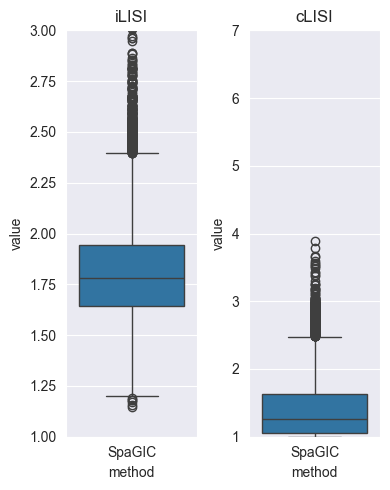

In [11]:
import harmonypy as hm

iLISI = hm.compute_lisi(batch_adata.obsm['Harmony_Revised'], batch_adata.obs[['batch_name']], label_colnames=['batch_name'])[:, 0]
cLISI = hm.compute_lisi(batch_adata.obsm['Harmony_Revised'], batch_adata.obs[['ground_truth']], label_colnames=['ground_truth'])[:, 0]

df_iLISI = pd.DataFrame({
    'method': 'SpaGIC',
    'value': iLISI,
    'type': ['ILISI'] * len(iLISI)
})

df_cLISI = pd.DataFrame({
    'method': 'SpaGIC',
    'value': cLISI,
    'type': ['CLISI'] * len(cLISI)
})

fig, axes = plt.subplots(1, 2, figsize=(4, 5))
sns.boxplot(data=df_iLISI, x='method', y='value', ax=axes[0])
sns.boxplot(data=df_cLISI, x='method', y='value', ax=axes[1])
axes[0].set_ylim(1, 3)
axes[1].set_ylim(1, 7)
axes[0].set_title('iLISI')
axes[1].set_title('cLISI')

plt.tight_layout()
print(np.median(iLISI))
print(np.median(cLISI))

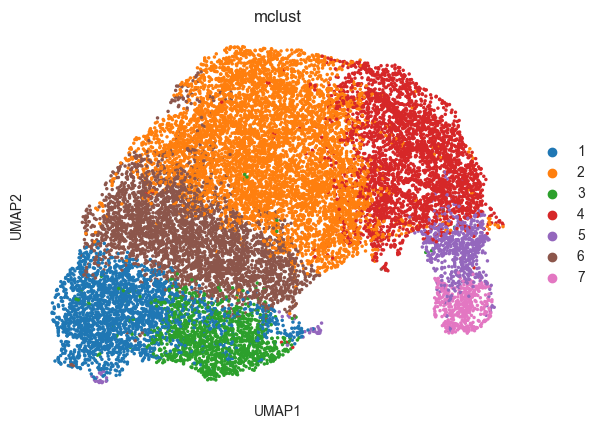

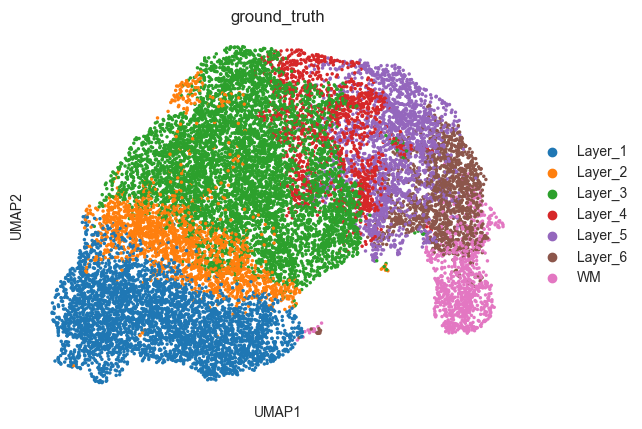

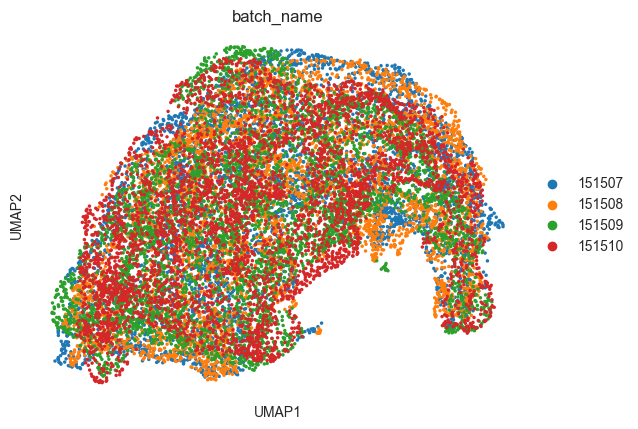

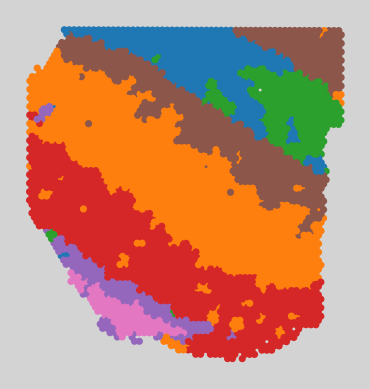

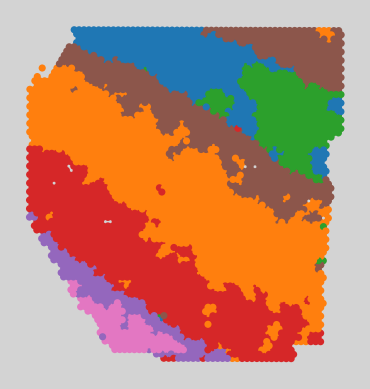

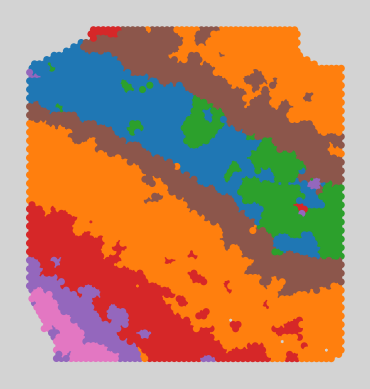

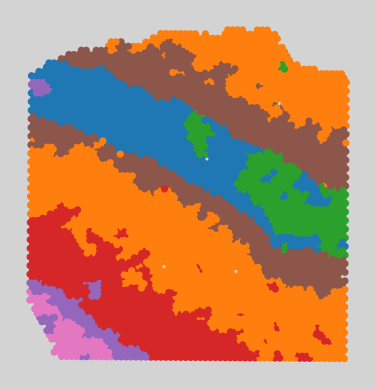

In [13]:
plt.rcParams['axes.facecolor'] = 'white'  # 设置子图的背景颜色
plt.rcParams['figure.facecolor'] = 'white'  # 设置整张图的背景颜色

sc.pp.neighbors(batch_adata, use_rep='Harmony_Revised', random_state=666)
sc.tl.umap(batch_adata, random_state=666)

sc.pl.umap(batch_adata, color=['mclust'], show=True, size=25, save='SpaGIC_M_Donor1.png')
sc.pl.umap(batch_adata, color=['ground_truth'], show=True, size=25, save='SpaGIC_G_Donor1.png')
sc.pl.umap(batch_adata, color=['batch_name'], show=True, size=25, save='SpaGIC_B_Donor1.png')

plt.rcParams['axes.facecolor'] = 'lightgray'  # 设置子图的背景颜色
plt.rcParams['figure.facecolor'] = 'lightgray'  # 设置整张图的背景颜色

for section_id in datasets:
    adata_tmp = batch_adata[batch_adata.obs['batch_name'] == section_id]
    sc.pl.spatial(adata_tmp, img_key=None, color=['mclust'], title=[''],
                  legend_fontsize=12, show=False, frameon=False, legend_loc=None,
                  spot_size=200)

    plt.savefig('figures/SpaGIC_' + section_id + '.png', dpi=300, bbox_inches='tight')